Importing dependencies and Data

In [5]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus :
  tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
import tensorflow_datasets as tfds # TF datasets
import matplotlib.pyplot as plt # For visualization

In [8]:
ds = tfds.load("fashion_mnist",split="train") #Getting the data for training

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFKW6QI/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFKW6QI/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Visualization

In [9]:
import numpy as np # Mainly for data transformation

In [10]:
#setting up an iterator [connection to the dataset]
dataiterator = ds.as_numpy_iterator()

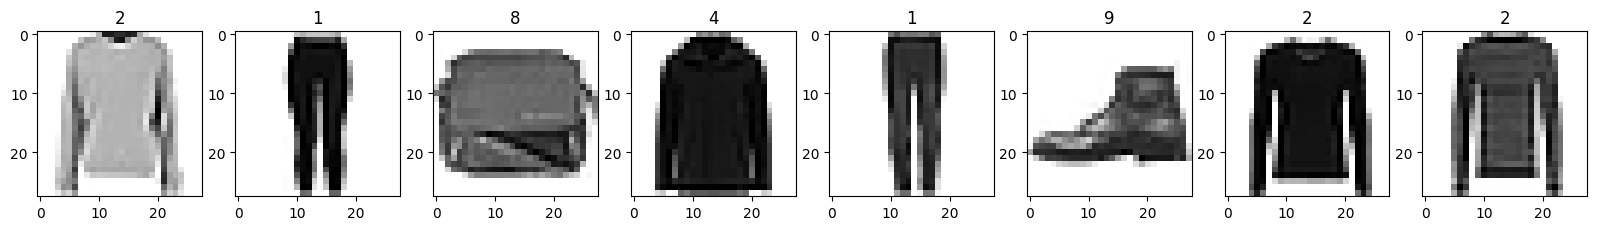

In [11]:
fig,axes =  plt.subplots(ncols = 8,figsize=(20,20)) #Setting up the grid
for ids in range(8) : #looping for 8 images
  sample = dataiterator.next() #getting the image and label
  axes[ids].imshow(np.squeeze(sample['image']),cmap = 'gray_r') #plotting the images
  axes[ids].title.set_text(sample['label']) #Setting the plot title as the label of that image

In [12]:
#Scaling images between 0 and 1
def scale_img(data):
  image = data["image"]
  return image/255

Steps for pipeline :
Map -> Cache -> Shuffle -> Batch -> Prefetch



In [13]:
ds = tfds.load("fashion_mnist",split = "train") # Loading the data again
ds = ds.map(scale_img) #Scaling the images and mapping them back to their original index
ds = ds.cache() # Cashing the data
ds = ds.shuffle(60000) # Shuffling the data
ds = ds.batch(128) # Batching it into 128 images
ds = ds.prefetch(64) #Pre fetching (Reduces the chances of bottlenecking)

In [14]:
print(f"(No of images,x,y,z) : {ds.as_numpy_iterator().next().shape}")

(No of images,x,y,z) : (128, 28, 28, 1)


## Building the network

Importing modeling components

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose

Building the generator

In [16]:
def Generator_build():
  model = Sequential()

  #taking random values and reshaping it to 7x7x128
  model.add(Dense(7*7*128,input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # UpSampling Block 2
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

  return model

In [17]:
generator = Generator_build()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                              

In [18]:
img = generator.predict(np.random.randn(8,128,1))
img.shape

1/1 [==============================] - 13s 13s/step


(8, 28, 28, 1)

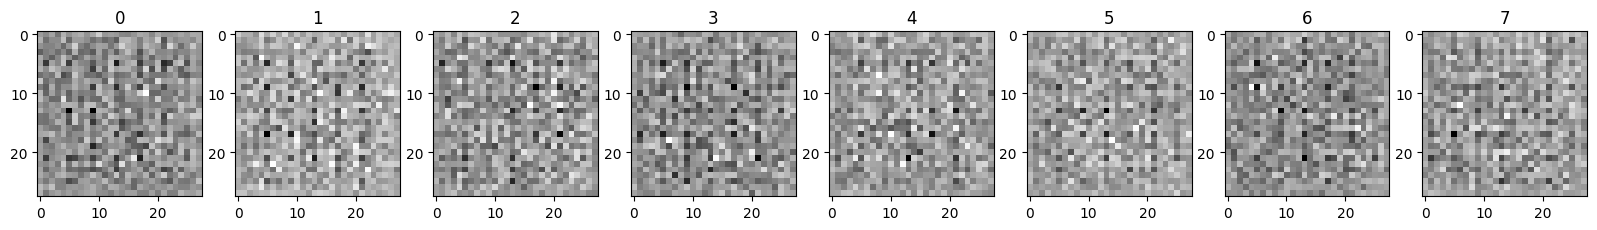

In [19]:
# Plotting the generated images
fig,axes =  plt.subplots(ncols = 8,figsize=(20,20)) #Setting up the grid
for ids,img in enumerate(img) : #looping for 8 images
  axes[ids].imshow(np.squeeze(img),cmap = 'gray_r') #plotting the images
  axes[ids].title.set_text(ids) #Setting the plot title as the label of that image

Building The Discriminatior

In [20]:
def Discriminator_build():
  model = Sequential()

  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape= (28,28,1)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

In [21]:
discriminator = Discriminator_build()

In [22]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)             

In [23]:
img = generator.predict(np.random.randn(8,128,1))
discriminator.predict(img)

1/1 [==============================] - 0s 133ms/step


array([[0.5094595 ],
       [0.5091971 ],
       [0.5091025 ],
       [0.5091622 ],
       [0.5090968 ],
       [0.5093543 ],
       [0.50906646],
       [0.50896657]], dtype=float32)

# Custom Training Loop

Setup Losses and Optimizers

In [24]:
from tensorflow.keras.optimizers import Adam #Adam Optimizer
from tensorflow.keras.losses import BinaryCrossentropy # BinaryCrossentrtopy for discriminator and for generator

In [25]:
g_opt = Adam(learning_rate=0.0002,beta_1 = 0.5)
d_opt = Adam(learning_rate=0.0002,beta_1 = 0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Build SubClass Model

In [26]:
from tensorflow.keras.models import Model

In [27]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args,**kwargs)

    # Attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    # Attributes for optimizers and losses
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training = False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
        yhat_real = self.discriminator(real_images,training = True)
        yhat_fake = self.discriminator(fake_images,training = True)
        yhat_realfake = tf.concat([yhat_real,yhat_fake],axis = 0)

        # Setting labels for the discriminator
        y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis = 0)

        # Adding some noise to the True outputs
        noise_real = -0.15*tf.random.normal(tf.shape(yhat_real))
        noise_fake = 0.15*tf.random.normal(tf.shape(yhat_fake))
        y_realfake += tf.concat([noise_real,noise_fake],axis = 0)

        # Calculating Loss
        total_d_loss = self.d_loss(y_realfake,yhat_realfake)

    # Apllying Backpropagation
    dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

    # Training the Generator
    with tf.GradientTape() as g_tape:

      # Generating New Images
      gen_images = self.generator(tf.random.normal((128,128,1)), training = True)

      # Creating Prediction labels
      predicted_labels = self.discriminator(gen_images, training = False)

      # Calculate loss - trick to training is to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

    # Applying  Backpropagation
    ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss" : total_d_loss, "g_loss" : total_g_loss}

  def eval(self):
    pass


In [28]:
# Instantizing the model
fashgan = FashionGAN(generator,discriminator)
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

Building CallBack


In [29]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
class ModelMonitor(Callback):
  def __init__(self,num_img = 4, latent_dim =128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self,epoch, logs = None):
    random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(f"Generated_img_{epoch}_{i}.png")

Training


In [32]:
#generator.load_weights('/content/drive/MyDrive/Fashion GAN/generator4.h5')
#discriminator.load_weights('/content/drive/MyDrive/Fashion GAN/discriminator4.h5')

In [ ]:
#hist = fashgan.fit(ds,epochs = 270, callbacks = [ModelMonitor()])

Reviewing Performance


In [ ]:
#plt.suptitle('Loss')
#plt.plot(hist.history['d_loss'], label = 'd_loss')
#plt.plot(hist.history['g_loss'],label = 'g_loss')
#plt.legend()
#plot = plt.show()


# Testing The Images

Generating Images

In [ ]:
generator.load_weights('') # load your weights here

In [40]:
imgs = generator.predict(tf.random.normal((16,128,1)))

1/1 [==============================] - 0s 18ms/step


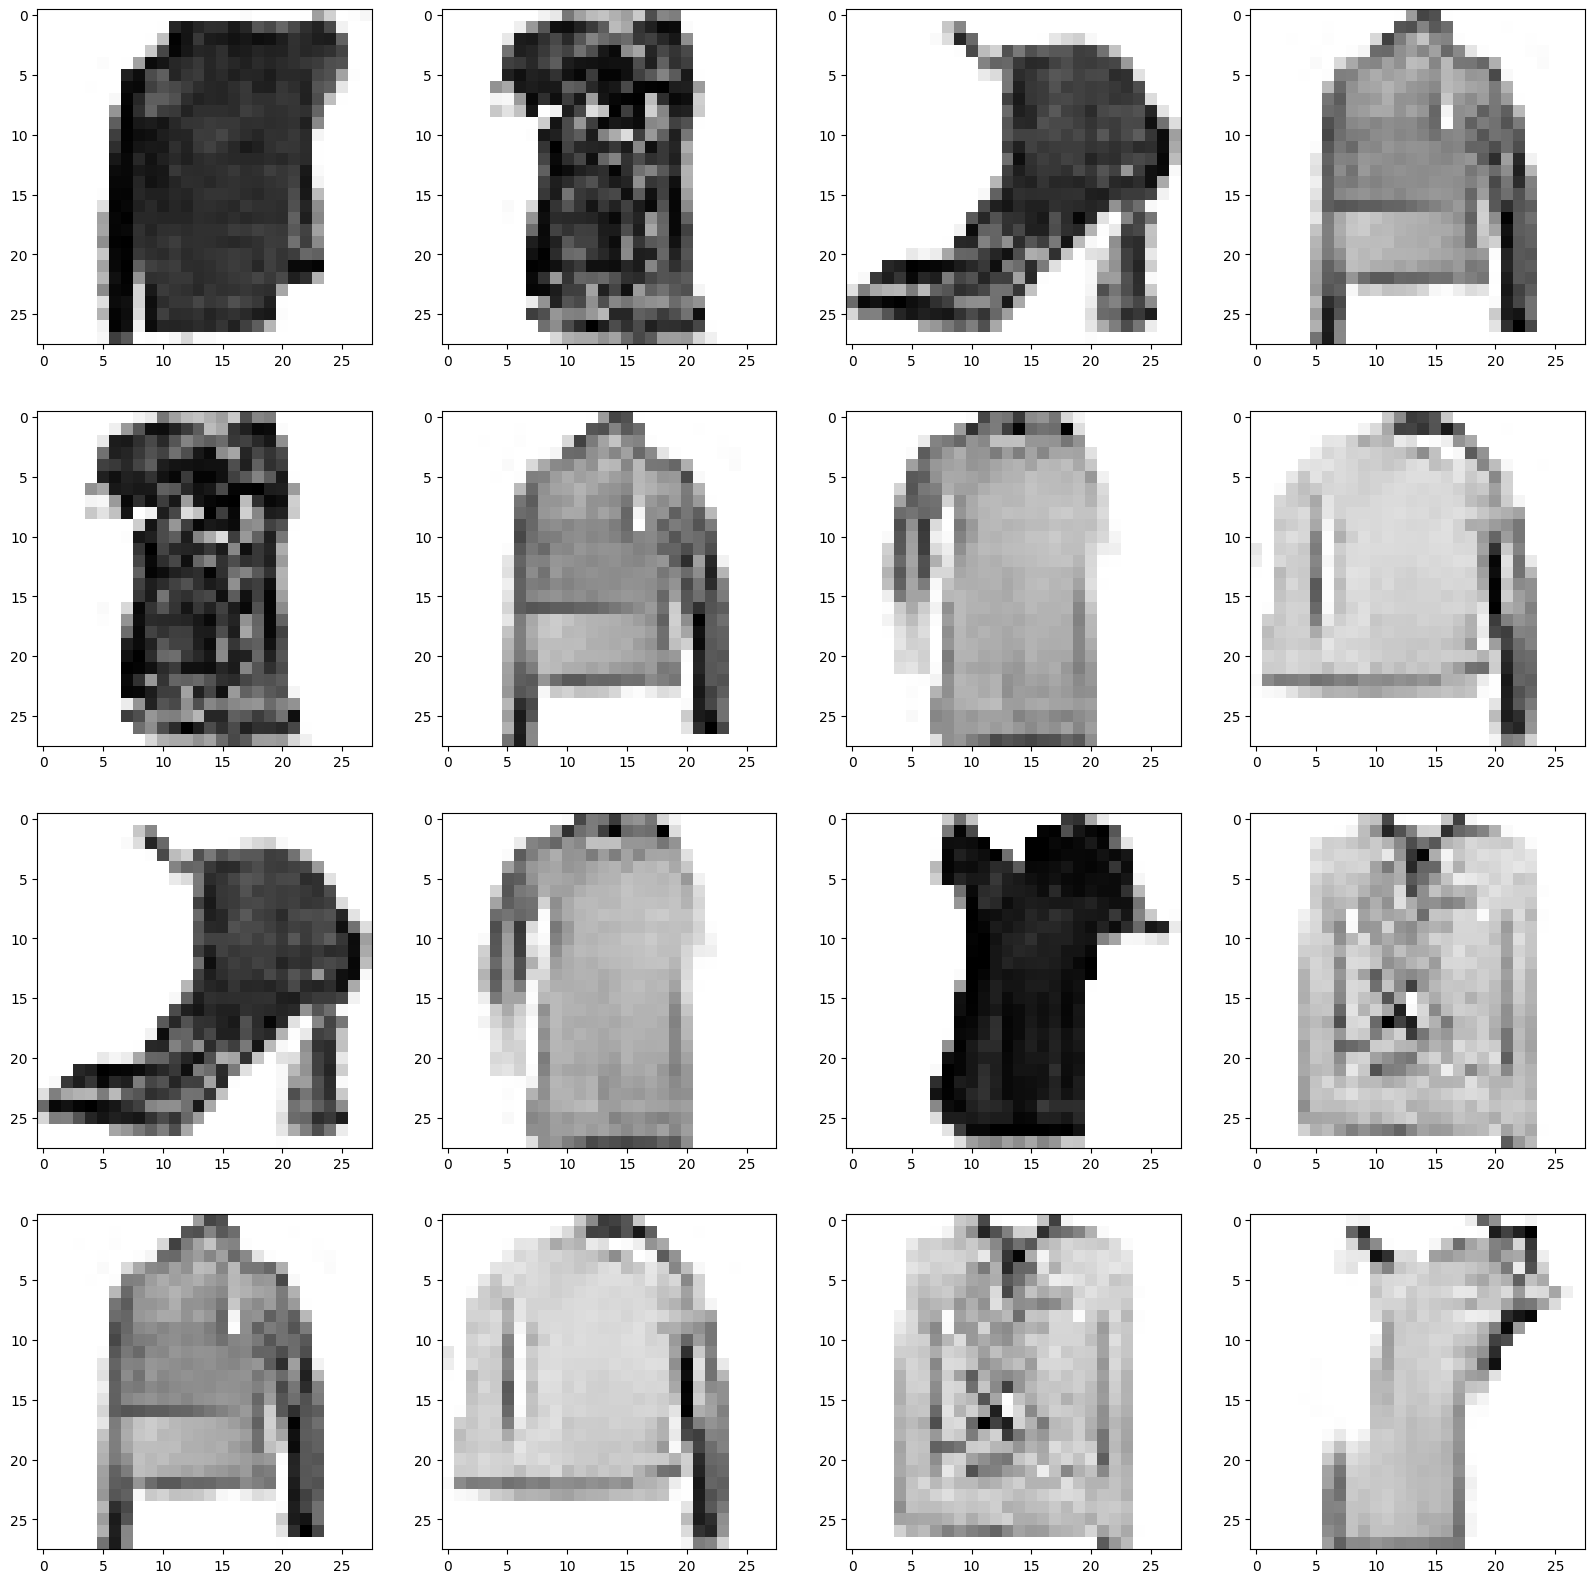

In [41]:
fig,ax = plt.subplots(ncols=4,nrows = 4,figsize = (20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1],cmap ='gray_r')


Save The Model

In [37]:
#generator.save('/content/drive/MyDrive/Fashion GAN/generator5.h5')
#discriminator.save('/content/drive/MyDrive/Fashion GAN/discriminator5.h5')